# Lab Assignment Six: Convolutional Network Architectures

Miller Boyd

## Introduction
In this lab, we will select a prediction task to perform on my dataset, evaluate a deep learning architecture, and tune hyper-parameters. This report aims to be comprehensive, containing all code, visualizations, and text required to reproduce the results. We will explain every assumption and each step taken in my analysis.

## Dataset
Cards Image Dataset for Classification

from kaggle:

About Dataset

This is a very high quality dataset of playing card images. All images are 224 X 224 X 3 in jpg format. All images in the dataset have been cropped so that only the image of a single card is present and the card occupies well over 50% of the pixels in the image. There are 7624 training images, 265 test images and 265 validation images. The train, test and validation directories are partitioned into 53 sub directories , one for each of the 53 types of cards. The dataset also includes a csv file which can be used to load the datasets.

## Dataset Selection
For this lab, we will select a dataset of image data, similarly to how we selected datasets in lab two. The dataset will consist of identically sized images and will be used for a multi-class classification task. We are not allowed to use MNIST, Fashion MNIST, or the sklearn digits dataset.

For this lab, I've chosen a dataset of playing card images, which meets my criteria of using image data for a multi-class classification task. This choice avoids common datasets like MNIST or Fashion MNIST, providing a fresh and challenging alternative.
Why Playing Cards?

    Diverse Classes: Each card in a deck offers a unique image, creating over 52 distinct classes to classify. This diversity tests the depth and effectiveness of convolutional neural networks.

    Consistent Image Sizes: Playing cards are uniformly sized, simplifying preprocessing and allowing us to focus more on model tuning rather than data wrangling.

    Augmentation Opportunities: The dataset lends itself well to image transformations such as rotations and flips, enhancing the robustness of my model by training it to recognize cards from various perspectives.

    Real-world Relevance: The ability to automatically recognize playing cards can be applied in digital gaming, automated card games, and even casino security, making this project practically applicable beyond academic purposes.

    Unique Challenge: Stepping away from overused datasets introduces us to unique challenges in image processing and deep learning, pushing us to deepen my understanding and skills in a real-world context.

In [42]:
import pandas as pd
from PIL import Image
import os

# Load the CSV file to get image paths
data_path = './images/cards.csv'
df = pd.read_csv(data_path)

# Base directory where your images are stored relative to this notebook
base_directory = './images/'

# Function to load an image
def load_image(image_path):
    try:
        full_path = os.path.join(base_directory, image_path)
        with Image.open(full_path) as img:
            return img.copy()  # Use copy to close the file handle after loading
    except IOError:
        print(f"Error opening image {full_path}")
        return None

# Apply the function to load images
df['image'] = df['filepaths'].apply(load_image)

df.head()


Error opening image ./images/train/ace of clubs/output


,class index,filepaths,labels,card type,data set,image
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train,<PIL.Image.Image image mode=RGB size=224x224 a...
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train,<PIL.Image.Image image mode=RGB size=224x224 a...
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train,<PIL.Image.Image image mode=RGB size=224x224 a...
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train,<PIL.Image.Image image mode=RGB size=224x224 a...
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train,<PIL.Image.Image image mode=RGB size=224x224 a...


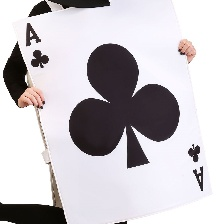

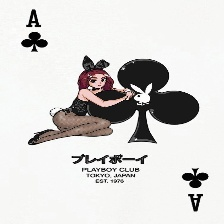

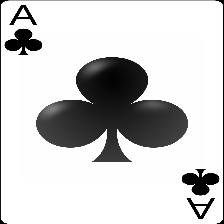

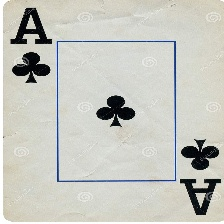

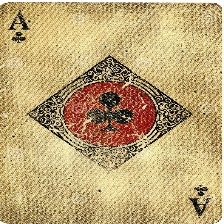

In [43]:
for x in range(5): display(df.loc[x, 'image'])

In [44]:
df['target'] = df['labels'].astype('category').cat.codes
df['card_val'] = df['card type'].astype('category').cat.codes

print(df['target'].unique())
print(df['card_val'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
[ 0  1  2  3  4 13  5  6  7  8  9 10 11 12]


I have encoded all card string names to an int value for ease of processing :). Now to clean up the dataset and remove uneccesary columns.

In [45]:
df = df.drop(columns=['class index','data set','labels','card type'])

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8155 entries, 0 to 8154
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  8155 non-null   object
 1   image      8154 non-null   object
 2   target     8155 non-null   int8  
 3   card_val   8155 non-null   int8  
dtypes: int8(2), object(2)
memory usage: 143.5+ KB


,target,card_val
count,8155.000000,8155.000000
mean,25.765788,6.036297
std,15.315650,3.812140
min,0.000000,0.000000
25%,12.000000,3.000000
50%,26.000000,6.000000
75%,39.000000,9.000000
max,52.000000,13.000000


### Preparation (3 points total)
#### Metric Selection (1.5 points)
Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

The F1 Score is a harmonic mean of precision and recall. This balance is crucial because in the context of card classification, both false positives and false negatives carry significant weight. For example, incorrectly classifying a card in a digital game or security system could disrupt the gameplay or trigger false alerts, respectively. Therefore, optimizing both precision (the accuracy of positive predictions) and recall (the ability to find all relevant instances) is essential.

#### Data Splitting Method (1.5 points)
Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

For my playing card image classification task, I've chosen to use Stratified Shuffle Split for dividing my data into training and testing sets. I picked this method for a few practical reasons that make sense for my specific needs and the nature of my data:

    Preservation of Class Distribution: my dataset probably doesn't have an even distribution of card types—some are likely more common than others. Using stratified sampling helps make sure that every training and test set mirrors the full dataset's class distribution, which is key to keeping my model fair and effective across all card types.

    Randomization: Shuffle splits add randomness to how we pick data points for the training and test sets. This is great for making the model more generalizable, reducing any bias that could come from the order of the data.

    Flexibility in Dataset Size: This method lets us choose exactly how much of my data to hold back for testing. This flexibility allows me to tailor the split based on how much data we have and what my training versus validation needs are.

    Realistic Mirroring of Practical Use: In real life, a model won't always get uniformly distributed data. The Stratified Shuffle Split mimics real-world conditions by ensuring the data split is both representative of the overall distribution and randomly shuffled. This approach helps prepare the model for how it will actually encounter data in practice, enhancing its reliability and effectiveness when deployed.

These reasons make Stratified Shuffle Split a solid choice for managing my data, aiming for a model that's both robust and closely aligned with real-world application requirements.

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

# Convert the 'image' column into a format that can be used with StratifiedShuffleSplit
X = list(df['image'])
y = df['target'].values

# Define the Stratified Shuffle Split object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = y[train_index], y[test_index]


### Modeling (6 points total)

#### Data Augmentation in Keras (1.5 points)
Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You should make use of Keras augmentation layers, like in the class examples.

#### CNN Architecture and Training (2 points)
Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures and investigate changing one or more parameters of each architecture such as the number of filters. This means, at a  minimum, you will train a total of four models (2 different architectures, with 2 parameters changed in each architecture). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

- **Performance Visualization:** [Insert the code and visualization for training and validation performance.]

#### CNN Performance Comparison (1.5 points)
Visualize the final results of all the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

#### Comparison with MLP (1 point)
Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

### Exceptional Work (1 point total)
- **Additional Analysis:** [Describe any additional analyses performed, such as using transfer learning with pre-trained weights and comparing its performance to your other models.]



## Conclusion
[Summarize the findings, challenges faced, and any insights gained from the lab exercise.]